In [ ]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from keras.optimizers import Adam

In [5]:
image_dir = Path('D:\\AIML\\FishImgClassificationProject\\Data\\train')
image_paths= list(image_dir.glob(r'**/*.jpg'))

# Get images and corresponding labels
images = [str(p) for p in image_paths]
labels = [os.path.split(os.path.split(p)[0])[1] for p in image_paths]

df = pd.DataFrame({'Image Path': images,'Label': labels})
print(df['Label'].unique())
print(df.head())

['animal fish' 'animal fish bass' 'fish sea_food black_sea_sprat'
 'fish sea_food gilt_head_bream' 'fish sea_food hourse_mackerel'
 'fish sea_food red_mullet' 'fish sea_food red_sea_bream'
 'fish sea_food sea_bass' 'fish sea_food shrimp'
 'fish sea_food striped_red_mullet' 'fish sea_food trout']
                                          Image Path        Label
0  D:\AIML\FishImgClassificationProject\Data\trai...  animal fish
1  D:\AIML\FishImgClassificationProject\Data\trai...  animal fish
2  D:\AIML\FishImgClassificationProject\Data\trai...  animal fish
3  D:\AIML\FishImgClassificationProject\Data\trai...  animal fish
4  D:\AIML\FishImgClassificationProject\Data\trai...  animal fish


In [6]:
df['Label'].value_counts()

Label
animal fish                         1096
fish sea_food trout                  580
fish sea_food red_mullet             579
fish sea_food shrimp                 576
fish sea_food hourse_mackerel        573
fish sea_food red_sea_bream          571
fish sea_food black_sea_sprat        569
fish sea_food gilt_head_bream        566
fish sea_food striped_red_mullet     547
fish sea_food sea_bass               538
animal fish bass                      30
Name: count, dtype: int64

In [13]:
def plot_history(history):
    """ Plots the graph of Accuracy and Loss over epochs with the history of the model """

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1)) 
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()

In [7]:
# Preprocess the Fish image data and create the train and test dataset
images_labels = [
    (str(p), os.path.split(os.path.split(p)[0])[1])
    for p in image_paths
]

total_size = df['Label'].count()
images_, labels_ = zip(*images_labels)

class_names = sorted(set(labels_))

class_to_index = {name: idx for idx, name in enumerate(class_names)}

numeric_labels = [class_to_index[label] for label in labels_]

dataset = tf.data.Dataset.from_tensor_slices((list(images_), list(numeric_labels)))

img_size = (128, 128)

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # normalize
    return image, label

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(buffer_size=total_size, reshuffle_each_iteration=True)

total_size = len(images_)
train_size = int(0.8 * total_size)

train_ds = dataset.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
print(train_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
test_images = []
test_labels = []

# Get the images and labels array from test dataset
for img_batch, label_batch in test_ds:
    test_images.extend(img_batch.numpy())
    test_labels.extend(label_batch.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Build the CNN model
CNN_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.0001),
                  input_shape=(128, 128 , 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(36, activation='softmax',
                 kernel_regularizer=regularizers.l2(0.0001))
])

# Compile the CNN model
CNN_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

callbacks = [early_stop, reduce_lr]

# Fit/Train the model with train dataset
history = CNN_model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    callbacks=callbacks,
    verbose=0
)

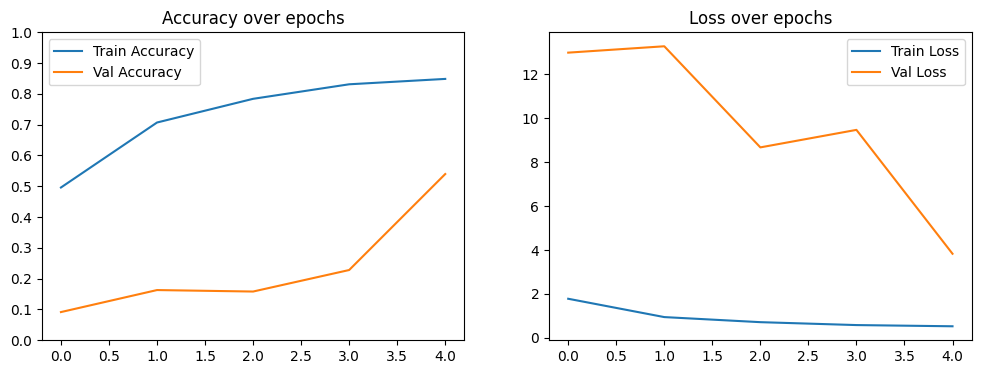

In [14]:
# Plot graph for Accuracy and Loss over Epochs
plot_history(history)

In [ ]:
# Evaluate the CNN model
results = CNN_model.evaluate(test_images, test_labels, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 3.97909
Test Accuracy: 53.09%


In [ ]:
# Predict and display the metrics of CNN model

prediction_probs = CNN_model.predict(test_images)
predictions = np.argmax(prediction_probs, axis=1)

y_true = test_labels

print(f"Prediction:\n")
print(f"Accuracy: {accuracy_score(y_true, predictions):.4f}")
print(f"Precision: {precision_score(y_true, predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_true, predictions, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_true, predictions, average='weighted'):.4f}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true, predictions)}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step
Prediction:

Accuracy: 0.5309
Precision: 0.4588
Recall: 0.5309
F1-Score: 0.4534
Confusion Matrix:
 [[185   0  10   0   1   9   6   1   8   6   0]
 [  7   0   0   0   0   0   0   0   0   0   0]
 [  0   0 103   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0  10   0   0  79   0]
 [  0   0  32   0   7   0   0   0  40  40   0]
 [  0   0   0   0   0 114   0   0   0   0   0]
 [  0   0   0   0   0   0  47   0   1  68   0]
 [  0   0  54   0   0   0   0   0   0  61   0]
 [  0   0   7   0   0   0   0   0 110   4   0]
 [  0   0   5   0   0   1   0   0   0  95   0]
 [  0   0  14   0   9   0  52   0   1  48   0]]


c:\Users\My Pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
